# ➡️ 동시 분류 모델

## multi-label labeling

In [46]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 🎈파라미터

In [47]:
# 일정한 시간 간격으로 음압을 측정하는 주파수, 22050Hz
hp_sample_rate = 44100

# -- wav 길이가 다양하기 때문에, 길면 자르고 짧으면 padding 붙여서 일정하게 조절.
# -- 잘린 wav가 0.1sec~0.3sec이니까 20(0.2sec~0.3sec)으로 결정
max_pad_len = 20

# -- return 될 mfcc의 개수
n_mfcc_feature = 40

# -- model input shape
n_row = n_mfcc_feature    
n_columns = max_pad_len    
n_channels = 1

# -- 구분할 class 개수 8개
# -- CC인지, HH인지...
n_classes = 8

# -- 결과가 0.5 이상이면 1, 아니면 0
predict_standard = 0.5

## ✨ Drum Mapping

In [48]:
"""
[1,0,0,0,0,0,0,0]	CC
[0,1,0,0,0,0,0,0]	HH
[0,0,1,0,0,0,0,0]	RC
[0,0,0,1,0,0,0,0]	ST
[0,0,0,0,1,0,0,0]	MT
[0,0,0,0,0,1,0,0]	SD
[0,0,0,0,0,0,1,0]	FT
[0,0,0,0,0,0,0,1]	KK
"""

"""
-- pattern 1 : KK, SD, HH
01  [0,1,0,0,0,0,0,1]   HH, KK
02  [0,1,0,0,0,0,0,0]   HH
03  [0,1,0,0,0,1,0,0]   HH, SD
04  [0,1,0,0,0,0,0,0]   HH
05  [0,1,0,0,0,0,0,1]   HH, KK
06  [0,1,0,0,0,0,0,1]   HH, KK
07  [0,1,0,0,0,1,0,0]   HH, SD
08  [0,1,0,0,0,0,0,0]   HH
"""
# [0,1,0,0,0,0,0,1] HH, KK
# [0,1,0,0,0,0,0,0] HH
# [0,1,0,0,0,1,0,0] HH, SD

"""
-- pattern 2 : KK, SD, HH
01  [0,1,0,0,0,0,0,1] HH, KK
02  [0,1,0,0,0,0,0,0] HH
03  [0,1,0,0,0,0,0,0] HH
04  [0,1,0,0,0,0,0,0] HH
05  [0,0,0,0,0,1,0,0] SD
06  [0,1,0,0,0,0,0,0] HH
07  [0,1,0,0,0,0,0,0] HH
08  [0,1,0,0,0,0,0,0] HH
09  [0,1,0,0,0,0,0,1] HH, KK
10  [0,1,0,0,0,0,0,0] HH
11  [0,1,0,0,0,0,0,0] HH
12  [0,1,0,0,0,0,0,0] HH
13  [0,0,0,0,0,1,0,0] SD
14  [0,1,0,0,0,0,0,0] HH
15  [0,1,0,0,0,0,0,0] HH
16  [0,1,0,0,0,0,0,0] HH
"""
# [0,1,0,0,0,0,0,1] HH, KK
# [0,1,0,0,0,0,0,0] HH
# [0,0,0,0,0,1,0,0] SD

# -- label
# [0,1,0,0,0,0,0,0] HH
# -- P1 : 02, 04, 08
# -- P2 : 02, 03, 04, 06, 07, 08, 10, 11, 12, 14, 15, 16
# 
# [0,0,0,0,0,1,0,0] SD
# -- P2 : 05, 13
# 
# [0,1,0,0,0,0,0,1] HH, KK
# -- P1 : 01, 05, 06
# -- P2 : 01, 09
# 
# [0,1,0,0,0,1,0,0] HH, SD
# -- P1 : 03, 07

# drum2code = {'CC':0, 'HH':1, 'KK':2, 'SD':3}
code2drum = {0:'CC', 1:'HH', 2:'RC', 3:'ST', 4:'MT', 5:'SD', 6:'FT', 7:'KK'} 

pattern = {'HH':[0,1,0,0,0,0,0,0],
           'SD':[0,0,0,0,0,1,0,0],
           'HH_KK':[0,1,0,0,0,0,0,1],
           'HH_SD':[0,1,0,0,0,1,0,0]}

p_hh_kk = pattern['HH_KK']
p_sd = pattern['SD']
p_hh = pattern['HH']
p_hh_sd = pattern['HH_SD']

p1_2code = {'0001':p_hh_kk,
            '0002':p_hh,
            '0003':p_hh_sd,
            '0004':p_hh,
            '0005':p_hh_kk,
            '0006':p_hh_kk,
            '0007':p_hh_sd,
            '0008':p_hh,}
p2_2code = {'0001':p_hh_kk,
            '0002':p_hh,
            '0003':p_hh,
            '0004':p_hh,
            '0005':p_sd,
            '0006':p_hh,
            '0007':p_hh,
            '0008':p_hh,
            '0009':p_hh_kk,
            '0010':p_hh,
            '0011':p_hh,
            '0012':p_hh,
            '0013':p_sd,
            '0014':p_hh,
            '0015':p_hh,
            '0016':p_hh,
            }
pattern2code = {'P1':p1_2code, 'P2':p2_2code}

## 🎈 feature 추출

In [49]:
root = "../data/tmp_test_wavs/"
test = root + "SD_16_0001_0003.wav"

def extract_feature(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, sr=hp_sample_rate, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc_feature)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0,0), (0, pad_width)), mode='constant')
        print('file name :', file_name, ', length:', audio.shape[0]/float(sample_rate), 'secs, ', 'mfccs:', mfccs.shape)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None
    return mfccs

extract_feature(test)

file name : ../data/tmp_test_wavs/SD_16_0001_0003.wav , length: 0.1 secs,  mfccs: (40, 20)


array([[-133.42014 , -116.225334, -123.30745 , -137.29604 , -151.7531  ,
        -160.73177 , -173.82843 , -186.08293 , -201.27118 ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [ 180.6018  ,  193.32797 ,  185.38258 ,  175.80338 ,  167.60333 ,
         169.53348 ,  165.68207 ,  162.93893 ,  166.02829 ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [ -45.401985,  -70.467926,  -83.31563 ,  -86.414505,  -87.53303 ,
         -79.46127 ,  -72.8864  ,  -68.26849 ,  -54.140312,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ],
       [  72.09031 ,   78.87429 ,   66.04321 ,   61.61489 ,   59.251457,
          57.06164 ,   56.685154,   60.340073,  

## 🎈 Data 가져와서 feature 추출

In [50]:
# -- onset 잘린 per drum data folder path
root_path = '../data/trimmed_pattern_drum_wavs'
wav_list = os.listdir(root_path)
wav_files = [os.path.join(root_path, file) for file in wav_list if file.endswith('.wav')]
print(len(wav_files))

data = []
for wav_file in wav_files:
    # -- feature: mfcc
    feature = extract_feature(wav_file)
    
    # -- class_label: 드럼 종류
    file_name = os.path.basename(wav_file)
    pattern_name = file_name[:2] # -- P1
    drum_name = file_name[-8:-4] # -- 0001
    
    class_label = pattern2code[pattern_name][drum_name]
    print(class_label)
    data.append([feature, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(data, columns=['feature','class_label'])

256
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0001.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 0, 0, 1]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0002.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 0, 0, 0]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0003.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 1, 0, 0]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0004.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 0, 0, 0]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0005.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 0, 0, 1]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0006.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 0, 0, 1]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0007.wav , length: 0.1 secs,  mfccs: (40, 20)
[0, 1, 0, 0, 0, 1, 0, 0]
file name : ../data/trimmed_pattern_drum_wavs/P1_08_0001_0008.wav , length: 0.1 secs,  mfccs: (40, 2

## 🎈 훈련(Train), 검증(Test) Dataset 생성

In [51]:
# -- one-hot-encoding
# 예를 들어, 자연수 1, 2, 3 있을 때 1:[1.0.0] / 2:[0.1.0] / 3:[0.0.1] 이런 식으로 변환
# 변환하는 이유는, 멀티 클래스(3~ 가지) 분류를 위해
# => 사람이 이해하기 쉬운 데이터를 컴퓨터가 이해하기 쉬운 데이터로 변환하는 기본적인 방법

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
yy= y
# le = LabelEncoder()
# yy = to_categorical(le.fit_transform(y)) # -- one-hot-encoding

In [52]:
# -- train, test 분류
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

print("one-hot-encoding 전 : ", y[:5])
print("one-hot-encoding 후 : ", yy[:5])

print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_train : ", x_val.shape)
print("y_train : ", y_val.shape)
print("x_test : ", x_test.shape)
print("y_test : ", y_test.shape)

one-hot-encoding 전 :  [[0 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1]]
one-hot-encoding 후 :  [[0 1 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1]]
x_train :  (163, 40, 20)
y_train :  (163, 8)
x_train :  (41, 40, 20)
y_train :  (41, 8)
x_test :  (52, 40, 20)
y_test :  (52, 8)


In [53]:
# input shape 조정
x_train = tf.reshape(x_train, [-1, n_row, n_columns, n_channels])
x_val = tf.reshape(x_val, [-1, n_row, n_columns, n_channels])
x_test = tf.reshape(x_test, [-1, n_row, n_columns, n_channels])

## 🎈 CNN 모델 생성

In [54]:
model = keras.Sequential()

model.add(layers.Conv2D(input_shape=(n_row, n_columns, n_channels), filters=16, kernel_size=(4,4), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=16*2, kernel_size=(4,4), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=16*3, kernel_size=(4,4), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
model.add(layers.Dense(units=n_classes, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 40, 20, 16)        272       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 20, 10, 16)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 20, 10, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 10, 32)        8224      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 10, 5, 32)         0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 10, 5, 32)        

## 🎈 훈련 binary_crossentropy

In [55]:
# -- epoch, batch, learning_rate
training_epochs = 40
batch_size = 20
opt_learning_rate = 0.001

opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# -- epoch Early Stopping 콜백 정의
# -- patience : 개선이 안 된다고 바로 종료시키지 않고, 몇 번의 에포크를 기다릴지 설정 (default = 0)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode = 'auto')
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data = (x_val, y_val), epochs=training_epochs, callbacks=[early_stopping])

stopped_epoch = early_stopping.stopped_epoch

Epoch 1/40
9/9 [==============================] - 5s 455ms/step - loss: 0.4332 - accuracy: 0.7485 - val_loss: 0.1718 - val_accuracy: 1.0000
Epoch 2/40
9/9 [==============================] - 0s 21ms/step - loss: 0.1710 - accuracy: 0.9755 - val_loss: 0.1005 - val_accuracy: 1.0000
Epoch 3/40
9/9 [==============================] - 0s 12ms/step - loss: 0.1410 - accuracy: 0.9816 - val_loss: 0.0987 - val_accuracy: 1.0000
Epoch 4/40
9/9 [==============================] - 0s 14ms/step - loss: 0.1138 - accuracy: 0.9755 - val_loss: 0.0749 - val_accuracy: 1.0000
Epoch 5/40
9/9 [==============================] - 0s 12ms/step - loss: 0.0822 - accuracy: 0.9693 - val_loss: 0.0605 - val_accuracy: 1.0000
Epoch 6/40
9/9 [==============================] - 0s 12ms/step - loss: 0.0791 - accuracy: 0.9816 - val_loss: 0.0360 - val_accuracy: 1.0000
Epoch 7/40
9/9 [==============================] - 0s 18ms/step - loss: 0.0639 - accuracy: 0.9755 - val_loss: 0.0365 - val_accuracy: 0.8049
Epoch 8/40
9/9 [==========

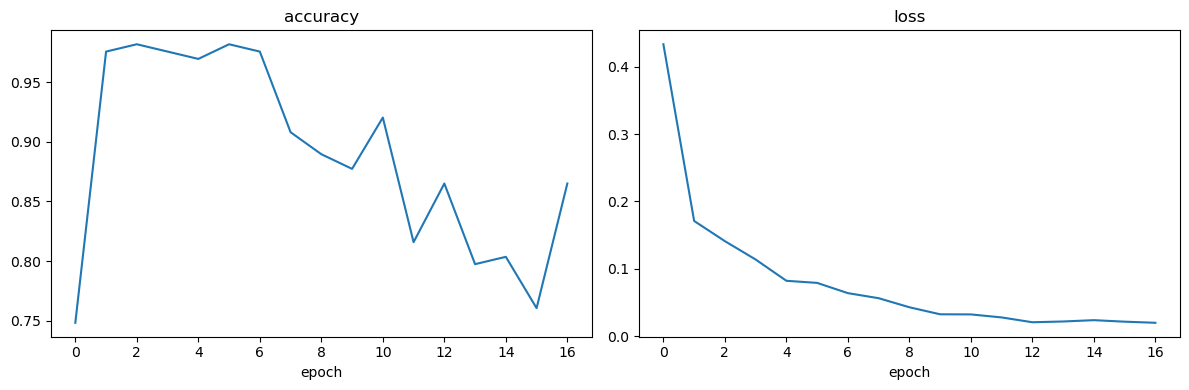

In [56]:
def vis(history, key):
    x = np.arange(0, len(history.history[key])) # -- stopped_epoch + 1
    y = list(history.history[key])
    plt.plot(x, y)
    plt.xlabel('epoch')
    plt.title(key)
    
def plot_history(history):
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx, key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()
    
plot_history(history)

## 🎈 모델 검증

In [57]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print('test loss:', results[0])
print('test accuracy:', results[1])


# Evaluate on test data
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - accuracy: 0.8500

3/3 [==============================] - 0s 15ms/step - loss: 0.0131 - accuracy: 0.8846
test loss: 0.013076642528176308
test accuracy: 0.8846153616905212


In [58]:
# -- multi-label이기 때문에, sigmoid라서 값이 0~1 사이니까 작업해줘야 함.
y_pred = model.predict(x_test)
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > predict_standard, 1, 0) # 0.5 보다크면 1, 작으면 0

_y_test = y_test.flatten() # 차원 펴주기
print(classification_report(_y_test, pred_class))

2/2 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       336
           1       0.99      1.00      0.99        80

    accuracy                           1.00       416
   macro avg       0.99      1.00      1.00       416
weighted avg       1.00      1.00      1.00       416



## 🎈 예측

In [65]:
root_path = "../data/tmp_test_wavs/"
# test_path = root_path + "CC_04_9949_0001.wav"
# test_path = root + "HH_08_0002_0004.wav"
# test_path = root + "KK_04_0001_0001.wav"
# test_path = root + "SD_16_0001_0003.wav"
# test_path = root + "SD_08_0004_0003.wav"
# test_path = '../data/trimmed_pattern_drum_wavs/P1_08_0001_0002.wav' # HH
# test_path = '../data/trimmed_pattern_drum_wavs/P1_08_0001_0003.wav' # HH, SD
# test_path = '../data/trimmed_pattern_drum_wavs/P2_16_0001_0001.wav' # HH, KK
# test_path = '../data/trimmed_pattern_drum_wavs/P2_16_0001_0002.wav' # HH
test_path = '../data/trimmed_pattern_drum_wavs/P2_16_0002_0013.wav' # SD

test = np.array(extract_feature(test_path))
test = tf.reshape(test, [-1, n_row, n_columns, n_channels])

predict = model.predict(test, batch_size=128)[0]
np.set_printoptions(precision=6, suppress=True)
print(os.path.basename(test_path),"의 결과:\n", predict)

sort_index = np.where(predict >= predict_standard)[0]

for idx in sort_index:
    print('>> ', code2drum[idx])

file name : ../data/trimmed_pattern_drum_wavs/P2_16_0002_0013.wav , length: 0.1 secs,  mfccs: (40, 20)
1/1 [==============================] - 0s 59ms/step
P2_16_0002_0013.wav 의 결과:
 [0.00018  0.8861   0.001541 0.000006 0.003146 0.97618  0.001495 0.000371]
>>  HH
>>  SD
